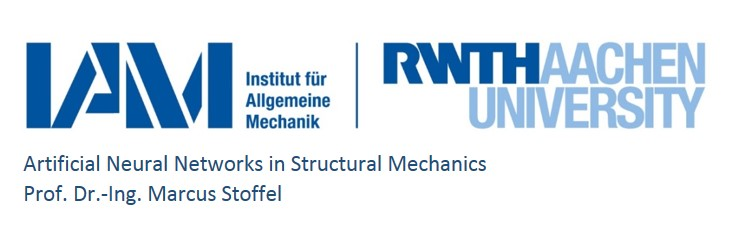

# Exercise 9

The goal of this exercise is to understand physics informed neural networks and solve the following PDE using the same using Dirichlet boundary conditions.
*******************************************************************************************************************************
PDE:
-------

### $$ G \ (u_{xx} + u_{yy}) + G \left( \frac{1+\nu}{1-\nu} \right) (u_{xx} + v_{yx}) = \sin(2\pi x) * \sin(2\pi y) $$
### $$ G \ (v_{xx} + v_{yy}) + G \left( \frac{1+\nu}{1-\nu} \right) (v_{yy} + u_{xy}) = \sin(\pi x)+ \sin(2\pi y) $$

where, $ u $ and $ v $ are deformations in the x and y directions respectively.

Task:
--------

* Import the data from csv file using pandas.
* Split the data into test and train, inputs and outputs.
* Setup layers required for computation.
* Train and save the model.
* Reload the model and predict the output using test data. 
* Plot errors.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib notebook

In [2]:
torch.manual_seed(22)
np.random.seed(22)

In [3]:
E = 1.0               # Young's Modulus in GPA
nu = 0.3              # Poisson Ratio
G = ((E/(2*(1+nu))))  

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())
        self.start_layer = 2
        self.end_layer = 7
        for i in range(self.start_layer, self.end_layer):                                                     
            self.net.add_module('Linear_layer_%d' % (i), nn.Linear(30, 30))       
            self.net.add_module('Tanh_activation_%d' % (i), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 2))                 

    # Feed Forward
    def forward(self, x):
        return self.net(x)

    # Compute losses at interior and boundaries alng with PI loss.
    # u_b and v_b are zeros since we are using dirichlet boundary conditions.
    def loss(self, x, x_bound, u_b, v_b, epoch):

        # Compute output for interior points
        y = self.net(x)                     
        # Compute output for boundary points        
        y_b= (self.net(x_bound)) 

        # Separate the outputs
        u_b_net, v_b_net = y_b[:, 0], y_b[:, 1]             
        u,v = y[:,0], y[:,1]                        

        # Calculate Gradients
        # Gradients of deformation in x-direction
        u_g = gradients(u, x)[0]                    
        u_x, u_y = u_g[:, 0], u_g[:, 1]             
        u_xx = gradients(u_x, x)[0][:, 0]           
        u_xy = gradients(u_x, x)[0][:, 1]           
        u_yy = gradients(u_y, x)[0][:, 1]           

        # Gradients of deformation in y-direction
        v_g = gradients(v, x)[0]                    
        v_x, v_y = v_g[:, 0], v_g[:, 1]             
        v_xx = gradients(v_x, x)[0][:, 0]           
        v_yx = gradients(v_y, x)[0][:, 0]
        v_yy = gradients(v_y, x)[0][:, 1]

        # Compute the physics informed losses
        f_1 = torch.sin(2*np.pi*x[:,0])*torch.sin(2*np.pi*x[:,1])
        f_2 = torch.sin(np.pi * x[:, 0])  + torch.sin(2 * np.pi * x[:, 1])
        loss_1 = (G*(u_xx + u_yy) + G*((1+nu)/(1-nu))*(u_xx + v_yx) - f_1)
        loss_2 = (G*(v_xx + v_yy) + G*((1 + nu) / (1 - nu))*(u_xy + v_yy) - f_2)

        loss_r = ((loss_1) ** 2).mean() + ((loss_2) ** 2).mean()
        loss_bc = ((u_b_net - u_b) ** 2).mean() + ((v_b_net - v_b) ** 2).mean()

        if epoch == 1:
            loss = loss_bc
            print(f'epoch {epoch}: loss_pde {loss_r:.8f}, loss_bc {loss_bc:.8f}')
        else:
            loss = loss_r + 1000*(loss_bc)
            print(f'epoch {epoch}: loss_pde {loss_r:.8f}, loss_bc {loss_bc:.8f}')
        return loss

In [5]:
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),allow_unused=True, create_graph=True)


def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

In [6]:
def Solve(interior_points, boundary_points,epochs,lr,outputfilename):

    ## parameters
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')                                                

    # Loading points from the mat file.
    data = scipy.io.loadmat(interior_points)                     
    x = data['x']                          
    y = data['y']                           
    xy_interior = np.concatenate((x, y), axis=1)                    
    

    bdry = scipy.io.loadmat(boundary_points)                    
    x_bdry = bdry['x_bdry']                
    y_bdry = bdry['y_bdry']
    xy_boundary = np.concatenate((x_bdry, y_bdry), axis=1)       
    

    # We only initialize u at boundary since v is also zero.
    u_bound_ext = np.zeros((len(xy_boundary)))[:, None]        


    ## Define data as PyTorch Tensor and send to device
    xy_f_train = torch.tensor(xy_interior, requires_grad=True, dtype=torch.float32).to(device)
    xy_b_train = torch.tensor(xy_boundary, requires_grad=True, dtype=torch.float32).to(device)
    xy_test = torch.tensor(xy_interior, requires_grad=True, dtype=torch.float32).to(device)
    u_b_train = torch.tensor(u_bound_ext, dtype=torch.float32).to(device)


    # Initialize model
    model = Model().to(device)

    # Loss and Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training
    def train(epoch):
        model.train()

        def setup():
            optimizer.zero_grad()
            loss_pde = model.loss(xy_f_train,xy_b_train,u_b_train,u_b_train,epoch)
            loss = loss_pde
            loss.backward()
            return loss


        loss = optimizer.step(setup)
        loss_value = loss.item() if not isinstance(loss, float) else loss
        if epoch%50==0:
            print(f'epoch {epoch}: loss {loss_value:.8f} ')

    print('start training...')
    start = time.time()
    for epoch in range(1, epochs + 1):
        train(epoch)
    end = time.time()
    print(f'total training time: {end - start}')
    
    u_preds = model(xy_test)
    # Compute gradients
    du = gradients(u_preds[:, 0], xy_test)[0]
    dv = gradients(u_preds[:, 1], xy_test)[0]
    u_x,v_y = du[:,0],dv[:,1]                                         # Strain in x and y direction
    u_pred = to_numpy(model(xy_test))
    scipy.io.savemat(outputfilename, {'x': x, 'y': y,
                                               'u': u_pred[:,0],
                                               'v': u_pred[:,1],
                                               'e_xx': to_numpy(u_x),
                                               'e_yy': to_numpy(v_y)})

In [7]:
Solve('Interior_Points_2.mat', 'Boundary_Points_2.mat',5000,0.005,'PINN_Solution_2.mat')

In [4]:
data_interior = scipy.io.loadmat('Interior_Points_2.mat')
data_boundary = scipy.io.loadmat('Boundary_Points_2.mat')
data_deform   = scipy.io.loadmat('PINN_Solution_2.mat')

In [5]:
x = np.squeeze(data_interior['x'])
y = np.squeeze(data_interior['y'])
z = np.squeeze(data_deform['u'])

# target grid to interpolate to
xi = yi = np.arange(0,1.01,0.01)
xi,yi = np.meshgrid(xi,yi)
mask = (xi < 0.5) & (yi > 0.5)

# Interpolation
zi = griddata((x,y),z,(xi,yi),method='cubic')

<IPython.core.display.Javascript object>


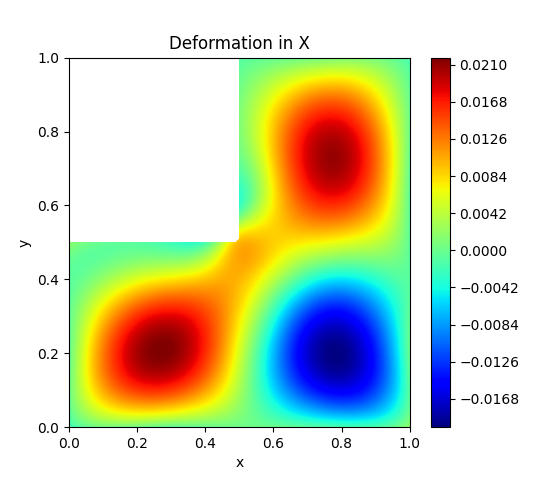

In [6]:
# masking and removing nan values as per domain boundary.
zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(5.5,4.8))
plt.contourf(xi,yi,zi,1000,cmap=plt.cm.jet)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Deformation in X')
plt.show()

In [7]:
Solve('Interior_Points_1.mat', 'Boundary_Points_1.mat',5000,0.005,'PINN_Solution_1.mat')

In [8]:
data_interior = scipy.io.loadmat('Interior_Points_1.mat')
data_boundary = scipy.io.loadmat('Boundary_Points_1.mat')
data_deform   = scipy.io.loadmat('PINN_Solution_1.mat')

In [9]:
x = np.squeeze(data_interior['x'])
y = np.squeeze(data_interior['y'])
z = np.squeeze(data_deform['u'])

# target grid to interpolate to
xi = yi = np.arange(0,1.01,0.01)
xi,yi = np.meshgrid(xi,yi)
mask = (xi < 0.5) & (yi > 0.5)

# Interpolation
zi = griddata((x,y),z,(xi,yi),method='cubic')

<IPython.core.display.Javascript object>


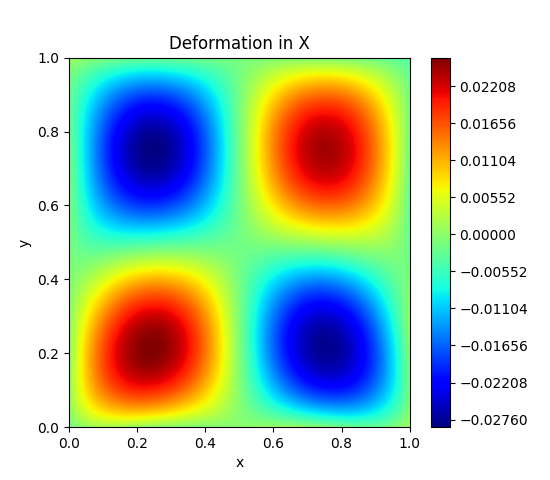

In [10]:
# plot
fig = plt.figure(figsize=(5.5,4.8))
plt.contourf(xi,yi,zi,1000,cmap=plt.cm.jet)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Deformation in X')
plt.show()

<IPython.core.display.Javascript object>


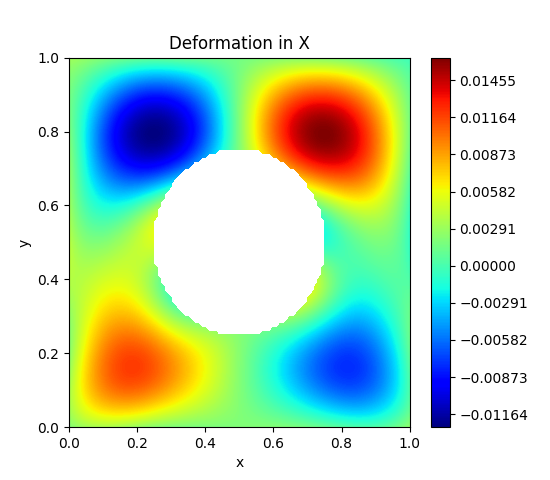

In [11]:
Solve('Interior_Points_3.mat', 'Boundary_Points_3.mat',5000,0.005,'PINN_Solution_3.mat')


data_interior = scipy.io.loadmat('Interior_Points_3.mat')
data_boundary = scipy.io.loadmat('Boundary_Points_3.mat')
data_deform   = scipy.io.loadmat('PINN_Solution_3.mat')

x = np.squeeze(data_interior['x'])
y = np.squeeze(data_interior['y'])
z = np.squeeze(data_deform['u'])

# target grid to interpolate to
xi = yi = np.arange(0,1.01,0.01)

xi,yi = np.meshgrid(xi,yi)

mask = ((xi-0.5)**2 + (yi-0.5)**2)**0.5<0.25

#Interpolation
zi = griddata((x,y),z,(xi,yi),method='cubic')

zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(5.5,4.8))
plt.contourf(xi,yi,zi,1000,cmap=plt.cm.jet)
plt.xlabel('x')
plt.ylabel('y')
# plt.colorbar()
plt.title('Deformation in X')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


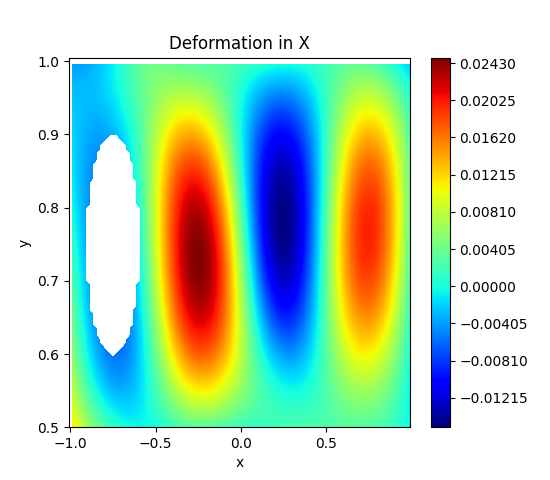

In [13]:
Solve('Interior_Points_4.mat', 'Boundary_Points_4.mat',5000,0.005,'PINN_Solution_4.mat')

data_interior = scipy.io.loadmat('Interior_Points_4.mat')
data_boundary = scipy.io.loadmat('Boundary_Points_4.mat')
data_deform   = scipy.io.loadmat('PINN_Solution_4.mat')

x = np.squeeze(data_interior['x'])
y = np.squeeze(data_interior['y'])
z = np.squeeze(data_deform['u'])

# target grid to interpolate to
xi = np.arange(-1.01,1.01,0.02)
yi = np.arange(0.5,1.01,0.005)
xi,yi = np.meshgrid(xi,yi)

mask = ((xi+0.75)**2 + (yi-0.75)**2)**0.5<0.15

# Interpolation
zi = griddata((x,y),z,(xi,yi),method='cubic')

zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(5.5,4.8))
plt.contourf(xi,yi,zi,1000,cmap=plt.cm.jet)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Deformation in X')
plt.show()

# Creating your own datasets

<IPython.core.display.Javascript object>


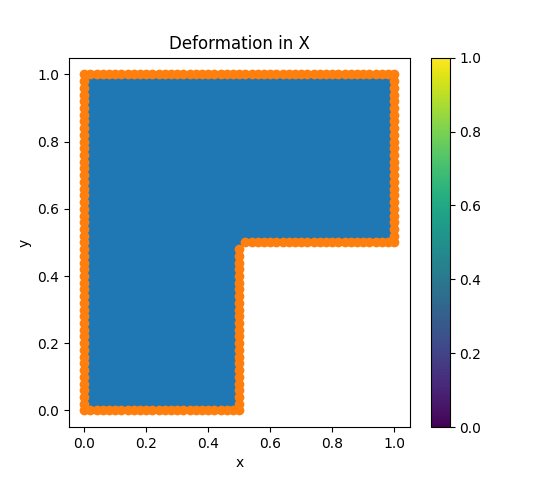

In [17]:
# Create your own datasets.

xi = np.arange(0,1.02,0.02)
yi = np.arange(0,1.02,0.02)

xi,yi = np.meshgrid(xi,yi)

mask = (xi > 0.5) & (yi < 0.5)

mask_b = (xi==0.0) | (yi==0) | (xi==1.0) | (yi==1.0) | ((xi==0.5) & (yi<0.5)) | ((xi>0.5) & (yi==0.5))

# Make a cut in the plate.
xi[mask] = np.nan
yi[mask] = np.nan

# Store the boundary points in an array.
xb = xi[mask_b]
yb = yi[mask_b]

# Exclude the boundary points from the interior points.
xi[mask_b] = np.nan
yi[mask_b] = np.nan


# Transform the 2D arrays to 1D for training the network.
x = xi.flatten()
y = yi.flatten()



x_bdry = xb.flatten()
y_bdry = yb.flatten()

# Visualize the data
fig = plt.figure(figsize=(5.5,4.8))
plt.scatter(x,y)
plt.scatter(xb,yb)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.ion()
plt.title('Deformation in X')
plt.show()